### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils import resample
from matplotlib.ticker import MaxNLocator

In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r"'force_all_finite' was renamed to 'ensure_all_finite'"
)

### Read File

In [3]:
# Reading the file
victim = pd.read_csv("Scamwatch_compile.csv")

In [4]:
victim.head()

,StartOfMonth,Address_State,Scam___Contact_Mode,Complainant_Age,Complainant_Gender,Category_Level_2,Category_Level_3,Amount_lost,Number_of_reports
0,4/1/22,Queensland,Text message,Under 18,Female,Attempts to gain your personal information,Phishing,"$3,886.00",2
1,5/1/22,Queensland,Text message,Under 18,Female,Attempts to gain your personal information,Phishing,"$5,794.00",3
2,8/1/22,Australian Capital Territory,Text message,18 - 24,Male,Attempts to gain your personal information,Phishing,$227.00,3
3,8/1/22,Australian Capital Territory,Text message,18 - 24,Female,Attempts to gain your personal information,Phishing,$898.00,2
4,7/1/22,Northern Territory,Text message,45 - 54,Female,Attempts to gain your personal information,Phishing,"$15,900.00",2


In [5]:
victim.tail()

,StartOfMonth,Address_State,Scam___Contact_Mode,Complainant_Age,Complainant_Gender,Category_Level_2,Category_Level_3,Amount_lost,Number_of_reports
127858,5/1/25,New South Wales,Online,18 - 24,Male,Investment scams,Investment scams,"$20,326.00",1
127859,7/1/25,New South Wales,Online,18 - 24,Male,Investment scams,Investment scams,"$1,600.00",1
127860,1/1/25,New South Wales,Online,Under 18,Male,Investment scams,Investment scams,$96.71,1
127861,5/1/25,New South Wales,Online,Under 18,Male,Investment scams,Investment scams,"$9,000.00",1
127862,6/1/25,New South Wales,Online,35 - 44,Male,Investment scams,Investment scams,"$55,030.00",3


In [6]:
victim.shape

(127863, 9)

### Checking for duplication

In [7]:
# Checking for duplications
victim.duplicated().sum()

np.int64(0)

### Checking for Nulls

In [8]:
# CHecking for nulls
missing_values = victim.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Amount_lost    65208
dtype: int64


In [ ]:
# Calculate and print the percentage of missing values in 'Amount_lost'
pct_missing = (victim['Amount_lost'].isnull().sum() / len(victim)) * 100
print(f"Amount_lost missing: {pct_missing:.2f}%")

Amount_lost missing: 51.00%


In [10]:
victim = victim[~victim['Amount_lost'].isnull()]

In [11]:
victim.dtypes

StartOfMonth           object
Address_State          object
Scam___Contact_Mode    object
Complainant_Age        object
Complainant_Gender     object
Category_Level_2       object
Category_Level_3       object
Amount_lost            object
Number_of_reports       int64
dtype: object

In [12]:
victim['Amount_lost'] = (
    victim['Amount_lost']
    .str.replace(r'[\$,]', '', regex=True)
    .str.strip()
)

In [13]:
victim['Amount_lost'] = pd.to_numeric(victim['Amount_lost'])

In [14]:
victim.dtypes

StartOfMonth            object
Address_State           object
Scam___Contact_Mode     object
Complainant_Age         object
Complainant_Gender      object
Category_Level_2        object
Category_Level_3        object
Amount_lost            float64
Number_of_reports        int64
dtype: object

In [ ]:
# Drop features
victim = victim.drop(['StartOfMonth', 'Address_State', 'Category_Level_2', 'Category_Level_3'], axis=1)

In [16]:
victim.duplicated().sum()

np.int64(30101)

In [17]:
vic_obj = victim.select_dtypes(include= ['object'])
for col in vic_obj.columns:
    print(f"\nColumn: {col}")
    print(vic_obj[col].value_counts())


Column: Scam___Contact_Mode
Scam___Contact_Mode
Online          20190
Email           15005
Phone call      12638
Text message     9742
In person        2770
Mail             2242
unspecified        52
Fax                16
Name: count, dtype: int64

Column: Complainant_Age
Complainant_Age
Unspecified    11460
65 and over     9395
35 - 44         9194
25 - 34         8852
45 - 54         8584
55 - 64         7997
18 - 24         5720
Under 18        1453
Name: count, dtype: int64

Column: Complainant_Gender
Complainant_Gender
Female                                    30017
Male                                      29698
X (Indeterminate/Intersex/Unspecified)     2940
Name: count, dtype: int64


In [ ]:
keep = (
    (victim['Complainant_Age'] != 'Unspecified')
    & (victim['Complainant_Gender'] != 'X (Indeterminate/Intersex/Unspecified)')
    & (~victim['Scam___Contact_Mode'].str.casefold().eq('unspecified'))
    & (victim['Amount_lost'].notnull() < 1000000)
)

victim = victim.loc[keep]

In [19]:
def amount_loss_grp (row):
    amount = row['Amount_lost']

    if amount < 100:
        level = 'Very Low Loss'
    elif amount < 1000:
        level = 'Low Loss'
    elif amount < 10000:
        level = 'Medium Loss'
    elif amount < 100000:
        level = 'High Loss'
    elif amount < 500000:
        level = 'Very High Loss'
    else:
        level = 'Extreme Loss'

    return level

In [20]:
victim['Amount_lost'] = victim.apply(amount_loss_grp, axis=1)

In [21]:
vic_obj = victim.select_dtypes(include= ['object'])
for col in vic_obj.columns:
    dummies = pd.get_dummies(victim[col], prefix=col, drop_first= False)
    victim = pd.concat([victim, dummies], axis=1)
victim.drop(columns=vic_obj.columns, inplace=True)

In [23]:
victim.shape

(50412, 23)

# K-Means

In [24]:
victim_fm = victim.copy()

In [25]:
victim_df = (
    victim_fm
    .groupby(victim_fm.columns.drop('Number_of_reports').tolist(), as_index=False)
    ['Number_of_reports'].sum()
    .rename(columns={'Number_of_reports': 'Total_Sample_Weight'})
)

vic_final = victim_df.drop(columns=['Total_Sample_Weight'])
vic_weight = victim_df['Total_Sample_Weight']

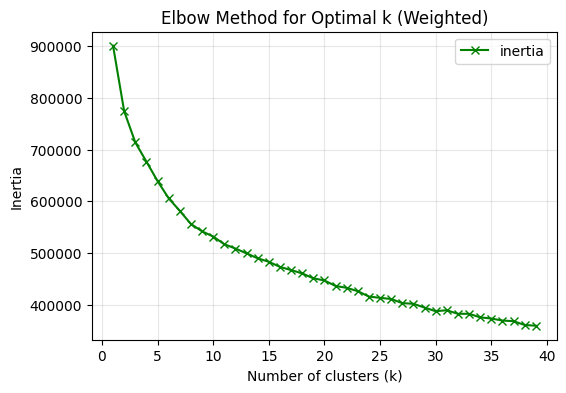

In [ ]:
k_range = range(1, 40)
inertia_w = []

for k in k_range:
    km = KMeans(n_clusters=k, n_init=50, random_state=222)
    km.fit(vic_final, sample_weight=vic_weight)
    inertia_w.append(km.inertia_)


elbow_df = pd.DataFrame({'k': list(k_range), 'inertia': inertia_w})
elbow_df.plot(
    x='k', y='inertia',
    kind='line', marker='x', color='green',
    title='Elbow Method for Optimal k (Weighted)',
    ylabel='Inertia',
    xlabel='Number of clusters (k)',
    figsize=(6,4)
)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
scores = []

for k in range(10, 30):
    km = KMeans(n_clusters=k, n_init=50, random_state=222)
    labels = km.fit_predict(vic_final, sample_weight=vic_weight)
    
    sil = silhouette_score(vic_final, labels)

    scores.append((k, sil))
    print(f"k={k:2d} | silhouette={sil:.3f}")

# Best k by silhouette
best_k = max(scores, key=lambda t: t[1])[0]
print("Best k with weight:", best_k)

k=10 | silhouette=0.082
k=11 | silhouette=0.083
k=12 | silhouette=0.076
k=13 | silhouette=0.069
k=14 | silhouette=0.080
k=15 | silhouette=0.061
k=16 | silhouette=0.069
k=17 | silhouette=0.067
k=18 | silhouette=0.063
k=19 | silhouette=0.065
k=20 | silhouette=0.068
k=21 | silhouette=0.063
k=22 | silhouette=0.063
k=23 | silhouette=0.070
k=24 | silhouette=0.086
k=25 | silhouette=0.074
k=26 | silhouette=0.065
k=27 | silhouette=0.065
k=28 | silhouette=0.070
k=29 | silhouette=0.076
Best k with weight: 24


In [ ]:
score_cosine = []

for k in range(10, 30):
    km = KMeans(n_clusters=k, n_init=50, random_state=222)
    labels = km.fit_predict(vic_final)
    
    sil = silhouette_score(vic_final, labels, metric='cosine')
    
    score_cosine.append((k, sil))
    print(f"k={k:2d} | silhouette(cosine)={sil:.3f}")

best_k_cosine = max(score_cosine, key=lambda t: t[1])[0]
print("Best k with cosine:", best_k_cosine)

k=10 | silhouette(cosine)=0.221
k=11 | silhouette(cosine)=0.198
k=12 | silhouette(cosine)=0.184
k=13 | silhouette(cosine)=0.166
k=14 | silhouette(cosine)=0.156
k=15 | silhouette(cosine)=0.167
k=16 | silhouette(cosine)=0.156
k=17 | silhouette(cosine)=0.153
k=18 | silhouette(cosine)=0.155
k=19 | silhouette(cosine)=0.157
k=20 | silhouette(cosine)=0.163
k=21 | silhouette(cosine)=0.166
k=22 | silhouette(cosine)=0.166
k=23 | silhouette(cosine)=0.171
k=24 | silhouette(cosine)=0.182
k=25 | silhouette(cosine)=0.184
k=26 | silhouette(cosine)=0.191
k=27 | silhouette(cosine)=0.196
k=28 | silhouette(cosine)=0.197
k=29 | silhouette(cosine)=0.209
Best k with cosine: 10


In [ ]:
score_cosine_w = []

for k in range(10, 30):
    km = KMeans(n_clusters=k, n_init=50, random_state=222)
    labels = km.fit_predict(vic_final, sample_weight=vic_weight)
    
    sil = silhouette_score(vic_final, labels, metric='cosine')
    
    score_cosine_w.append((k, sil))
    print(f"k={k:2d} | silhouette(cosine)={sil:.3f}")

best_k_cosine = max(score_cosine_w, key=lambda t: t[1])[0]
print("Best k with cosine:", best_k_cosine)

k=10 | silhouette(cosine)=0.148
k=11 | silhouette(cosine)=0.151
k=12 | silhouette(cosine)=0.137
k=13 | silhouette(cosine)=0.123
k=14 | silhouette(cosine)=0.144
k=15 | silhouette(cosine)=0.108
k=16 | silhouette(cosine)=0.124
k=17 | silhouette(cosine)=0.120
k=18 | silhouette(cosine)=0.109
k=19 | silhouette(cosine)=0.117
k=20 | silhouette(cosine)=0.121
k=21 | silhouette(cosine)=0.111
k=22 | silhouette(cosine)=0.110
k=23 | silhouette(cosine)=0.124
k=24 | silhouette(cosine)=0.152
k=25 | silhouette(cosine)=0.130
k=26 | silhouette(cosine)=0.116
k=27 | silhouette(cosine)=0.115
k=28 | silhouette(cosine)=0.124
k=29 | silhouette(cosine)=0.135
Best k with cosine: 24


# HDBSCAN - Hamming

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=10,
    metric='hamming',
    cluster_selection_method='eom',
    cluster_selection_epsilon=0.05
)
labels = clusterer.fit_predict(vic_final)

In [ ]:
mask = labels != -1
k = np.unique(labels[mask]).size
noise = (~mask).mean()
print(f"Clusters found: {k}")
print(f"Noise: {noise:.1%}")

if mask.sum() > 1 and k > 1:
    sil = silhouette_score(vic_final[mask], labels[mask], metric='hamming')
    print(f"Global Silhouette (non-noise): {sil:.3f}")

Clusters found: 2
Noise: 3.8%
Global Silhouette (non-noise): 0.019


In [ ]:
feature_cols = [c for c in vic_final.columns if not c.startswith('Amount_loss_grp_')]
X = vic_final[feature_cols].to_numpy()

best = None
best_key = None

for mcs in [10, 12, 15, 20, 50, 100, 120, 150, 200]:
    for ms in [8, 10, 20, 50, 75, 100]:
        for eps in [0.0, 0.01, 0.02, 0.05, 0.1]:
            cl = hdbscan.HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                metric='hamming',
                cluster_selection_method='eom',
                cluster_selection_epsilon=eps
            )
            lab = cl.fit_predict(X)

            mask = lab != -1
            k = np.unique(lab[mask]).size
            noise = (~mask).mean()

            if mask.sum() > 1 and k > 1:
                sil = silhouette_score(X[mask], lab[mask], metric='hamming')
            else:
                sil = float('nan')

            if not np.isnan(sil):
                key = (sil, -noise, k)
                if best_key is None or key > best_key:
                    best_key = key
                    best = (sil, noise, k, mcs, ms, eps, cl, lab)

if best:
    sil, noise, k, mcs, ms, eps, clusterer, labels = best
    print(f"BEST (HDBSCAN/hamming): sil={sil:.3f}, noise={noise:.1%}, k={k}, "
          f"mcs={mcs}, ms={ms}, eps={eps}")
else:
    print("No valid clustering with ≥2 non-noise clusters was found.")

BEST (HDBSCAN/hamming): sil=0.057, noise=80.7%, k=2, mcs=200, ms=8, eps=0.0


# HDBSCAN based on best parameter

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,
    min_samples=8,
    metric='hamming',
    cluster_selection_method='eom',
    cluster_selection_epsilon=0.0
)
labels = clusterer.fit_predict(vic_final)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise} / {len(labels)} ({n_noise/len(labels):.1%})")

Clusters found: 2
Noise points: 3642 / 4511 (80.7%)


In [ ]:
mask = labels != -1
if mask.sum() > 1 and np.unique(labels[mask]).size > 1:
    X = vic_final[mask]
    y = labels[mask]

    sil_global = silhouette_score(X, y, metric='hamming')
    print(f"Global Silhouette (non-noise): {sil_global:.3f}")

    s = pd.Series(silhouette_samples(X, y, metric='hamming'), index=y)
    means = s.groupby(level=0).mean().round(3)

    print("\nPer-cluster silhouette (mean):")
    print(means)
    best_cluster = means.idxmax()
    best_score = means.max()
    print(f"\nHighest silhouette cluster: {best_cluster} ({best_score:.3f})")
else:
    print("Silhouette not available (need ≥2 clusters among non-noise points).")

Global Silhouette (non-noise): 0.057

Per-cluster silhouette (mean):
0    0.105
1    0.027
dtype: float64

Highest silhouette cluster: 0 (0.105)


# HDBSCAN manhattan

In [ ]:
feature_cols = [c for c in vic_final.columns if not c.startswith('Amount_loss_grp_')]
X = vic_final[feature_cols].to_numpy()   

In [ ]:
metric = 'manhattan'

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=10,
    metric= metric,
    cluster_selection_method='eom',
    cluster_selection_epsilon=0.05
)

labels = clusterer.fit_predict(X)

In [ ]:
mask = labels != -1
k = np.unique(labels[mask]).size
noise = (~mask).mean()
print(f"Clusters found: {k}")
print(f"Noise: {noise:.1%}")

if mask.sum() > 1 and k > 1:
    sil = silhouette_score(vic_final[mask], labels[mask], metric= metric)
    print(f"Global Silhouette (non-noise): {sil:.3f}")

Clusters found: 2
Noise: 3.9%
Global Silhouette (non-noise): 0.010


In [ ]:
best = None
best_key = None

for mcs in [10, 12, 15, 20, 50, 100, 120, 150, 200]:
    for ms in [8, 10, 20, 50, 75, 100]:
        for eps in [0.0, 0.01, 0.02, 0.05, 0.1]:
            cl = hdbscan.HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                metric= metric,
                cluster_selection_method='eom',
                cluster_selection_epsilon=eps
            )
            lab = cl.fit_predict(X)

            mask = lab != -1
            k = np.unique(lab[mask]).size
            noise = (~mask).mean()

            if mask.sum() > 1 and k > 1:
                sil = silhouette_score(X[mask], lab[mask], metric= metric)
            else:
                sil = float('nan')

            if not np.isnan(sil):
                key = (sil, -noise, k)
                if best_key is None or key > best_key:
                    best_key = key
                    best = (sil, noise, k, mcs, ms, eps, cl, lab)

if best:
    sil, noise, k, mcs, ms, eps, clusterer, labels = best
    print(f"BEST (HDBSCAN/manhattan): sil={sil:.3f}, noise={noise:.1%}, k={k}, "
          f"mcs={mcs}, ms={ms}, eps={eps}")
else:
    print("No valid clustering with ≥2 non-noise clusters was found.")

BEST (HDBSCAN/manhattan): sil=0.050, noise=54.8%, k=2, mcs=150, ms=10, eps=0.0


# Best parameter for manhattan

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=150,
    min_samples=10,
    metric='manhattan',
    cluster_selection_method='eom',
    cluster_selection_epsilon=0.00
)

labels = clusterer.fit_predict(X)

In [ ]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise} / {len(labels)} ({n_noise/len(labels):.1%})")

mask = labels != -1
if mask.sum() > 1 and np.unique(labels[mask]).size > 1:
    X = X[mask]
    y = labels[mask]

    sil_global = silhouette_score(X, y, metric='manhattan')
    print(f"\nGlobal Silhouette (non-noise): {sil_global:.3f}")

    s = pd.Series(silhouette_samples(X, y, metric='manhattan'), index=y)
    means = s.groupby(level=0).mean().round(3)

    print("\nPer-cluster silhouette (mean):")
    print(means)

    best_cluster = means.idxmax()
    best_score = means.max()
    print(f"\nHighest silhouette cluster: {best_cluster} ({best_score:.3f})")

else:
    print("\nSilhouette not available (need ≥2 clusters among non-noise points).")

Clusters found: 2
Noise points: 1061 / 2037 (52.1%)

Global Silhouette (non-noise): 0.067

Per-cluster silhouette (mean):
0    0.067
1    0.065
dtype: float64

Highest silhouette cluster: 0 (0.067)


# Hierarchy Model

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet

In [ ]:
feature_cols = [c for c in vic_final.columns if not c.startswith('Amount_loss_grp_')]
X = vic_final[feature_cols].to_numpy()

In [ ]:
metric = 'cityblock'
linkage_method= 'average'

sil_scores = []
k_values = range(2, 21)

for k in k_values:
    model = AgglomerativeClustering(n_clusters=k, metric=metric, linkage=linkage_method)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels, metric=metric)
    sil_scores.append(sil)

best_idx = int(np.argmax(sil_scores))
best_k = k_values[best_idx]
print(f"Best k by silhouette: k={best_k} (score={sil_scores[best_idx]:.3f})")


Best k by silhouette: k=2 (score=0.166)


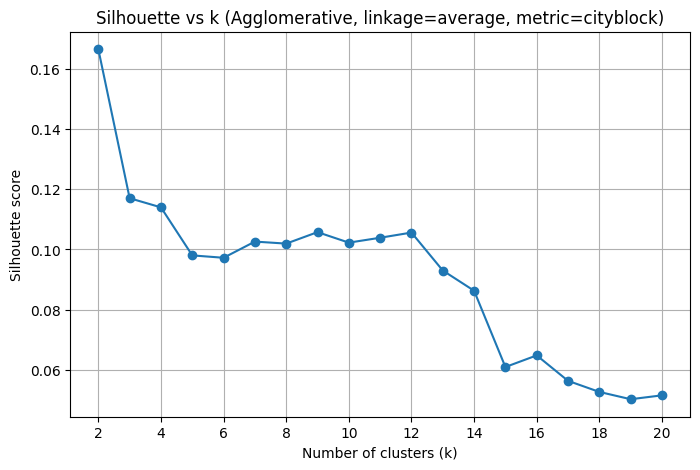

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(list(k_values), sil_scores, marker='o')
plt.title(f"Silhouette vs k (Agglomerative, linkage={linkage_method}, metric={metric})")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
D = pdist(X, metric=metric)
Z = linkage(D, method=linkage_method, optimal_ordering=True)

coph, _ = cophenet(Z, D)
print(f"Cophenetic correlation: {coph:.3f}")

Cophenetic correlation: 0.515


In [ ]:
def threshold_for_k(Z, k):
    m = Z.shape[0] + 1 
    if k <= 1 or k > m:
        raise ValueError("k must be in [2, m]")
  
    return Z[-(k - 1), 2] - 1e-12

Silhouette at dendrogram cut (k=2): 0.166


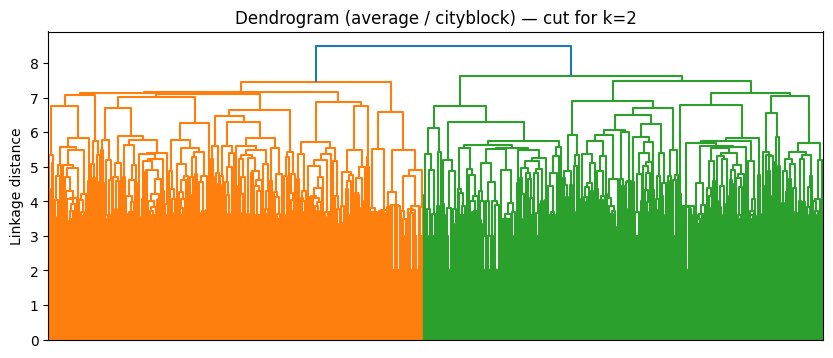

In [ ]:
t = threshold_for_k(Z, best_k)
labels_from_Z = fcluster(Z, t, criterion='distance')

sil_Z = silhouette_score(X, labels_from_Z, metric=metric)
print(f"Silhouette at dendrogram cut (k={best_k}): {sil_Z:.3f}")

plt.figure(figsize=(10, 4))
dendrogram(Z, no_labels=True, color_threshold=t)
plt.title(f"Dendrogram ({linkage_method} / {metric}) — cut for k={best_k}")
plt.ylabel("Linkage distance")
plt.show()

In [ ]:
feature_cols = [c for c in vic_final.columns if not c.startswith('Amount_loss_grp_')]
X = vic_final[feature_cols].to_numpy()
X = X.astype(bool)

In [ ]:
metric = 'hamming'
linkage_method = 'average'

In [ ]:
sil_scores = []
k_values = range(2, 21)

for k in k_values:
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage=linkage_method,
        metric=metric
    )
    labels = model.fit_predict(X)

    sil = silhouette_score(X, labels, metric=metric)
    sil_scores.append(sil)

best_idx = int(np.argmax(sil_scores))
best_k = k_values[best_idx]
print(f"Best k by silhouette: k={best_k} (score={sil_scores[best_idx]:.3f})")

Best k by silhouette: k=2 (score=0.188)


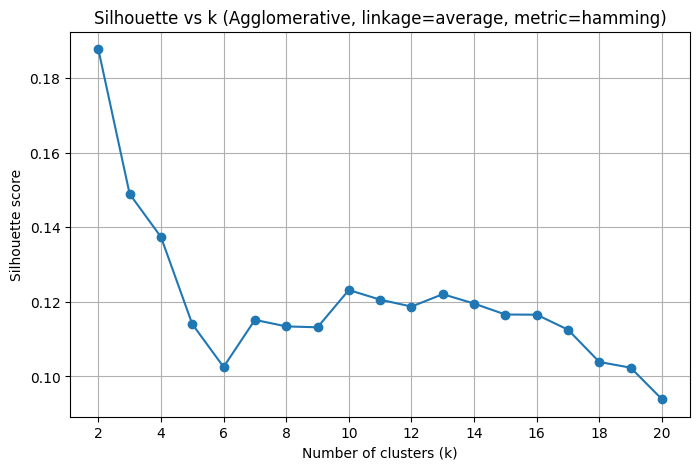

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(list(k_values), sil_scores, marker='o')
plt.title(f"Silhouette vs k (Agglomerative, linkage={linkage_method}, metric={metric})")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# Trying UMAP

In [27]:
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [32]:
feature_cols = [c for c in vic_final.columns if not c.startswith('Amount_loss_grp_')]
X = vic_final[feature_cols].to_numpy().astype(bool)

In [ ]:
um = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    metric="hamming",
    random_state=42
)

X_umap = um.fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
um = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=10,
    metric="hamming",
    random_state=42
)

X_umap = um.fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [34]:
sil_scores = []
k_values = range(2, 21)

for k in k_values:
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage="average",
        metric="euclidean"
    )
    labels = model.fit_predict(X_umap)
    sil = silhouette_score(X_umap, labels, metric="euclidean")
    sil_scores.append(sil)

best_idx = int(np.argmax(sil_scores))
best_k = k_values[best_idx]

print(f"Best k on UMAP: {best_k}, silhouette={sil_scores[best_idx]:.3f}")

Best k on UMAP: 2, silhouette=0.847


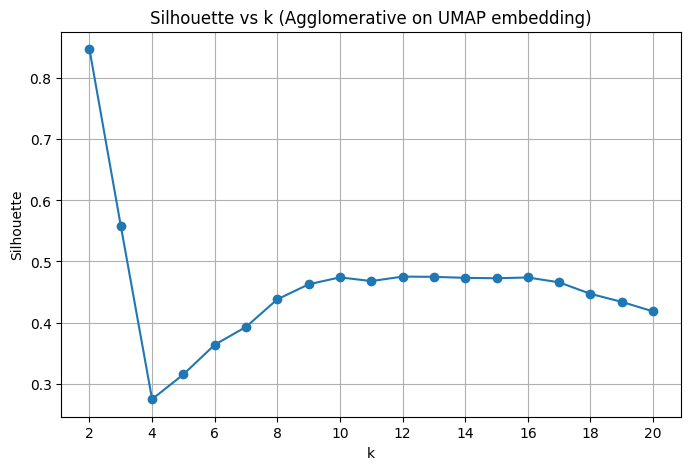

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Silhouette vs k (Agglomerative on UMAP embedding)")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


In [36]:
final_model = AgglomerativeClustering(
    n_clusters= 10,
    linkage="average",
    metric="euclidean"
)
final_labels = final_model.fit_predict(X_umap)


In [ ]:
X_bool = X.astype(bool)

umap_model = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=10,
    metric="hamming",
    random_state=222
)
X_umap = umap_model.fit_transform(X_bool)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [39]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

agg = AgglomerativeClustering(n_clusters=7, linkage="average", metric="euclidean")
lab_agg = agg.fit_predict(X_umap)
sil_agg = silhouette_score(X_umap, lab_agg, metric="euclidean")
print(f"Agglomerative: k=10, silhouette={sil_agg:.3f}")


Agglomerative: k=10, silhouette=0.368


In [40]:
km = KMeans(n_clusters=7, n_init=50, random_state=222)
lab_km = km.fit_predict(X_umap)
sil_km = silhouette_score(X_umap, lab_km, metric="euclidean")
print(f"KMeans:        k=10, silhouette={sil_km:.3f}")

KMeans:        k=10, silhouette=0.371


In [41]:
vic_final = vic_final.copy()
vic_final["cluster_kmeans"] = lab_km

In [ ]:
vic_final.to_csv("victim_clusters_kmeans_umapv2.csv", index=False)

In [ ]:
vic_final = vic_final.copy()
vic_final["cluster"] = pd.Series(lab_km, index=vic_final.index)

feature_cols = [c for c in vic_final.columns
                if c not in {"cluster", "cluster_kmeans"}
                and not c.startswith("Amount_loss_grp_")]

vf = vic_final.copy()
vf[feature_cols] = (vf[feature_cols] > 0).astype(int)

prev_wide = vf.groupby("cluster")[feature_cols].mean()

profile_long = (
    prev_wide.T
    .stack()
    .rename("prevalence")
    .reset_index()
    .rename(columns={"level_0": "feature"})
    .sort_values(["cluster", "prevalence"], ascending=[True, False])
)

overall_prev = vf[feature_cols].mean().rename("overall_prevalence")
cluster_sizes = vf["cluster"].value_counts().rename("cluster_size")
profile_long = profile_long.merge(overall_prev, left_on="feature", right_index=True, how="left")
profile_long["lift"] = (profile_long["prevalence"] / profile_long["overall_prevalence"]).replace([np.inf, -np.inf], np.nan)
profile_long = profile_long.merge(cluster_sizes, left_on="cluster", right_index=True, how="left")

profile_long[["feature", "cluster", "prevalence"]].to_csv("cluster_profile_simple_wo_cat_umap.csv", index=False)
print("Saved: cluster_profile_simple.csv")

Saved: cluster_profile_simple.csv


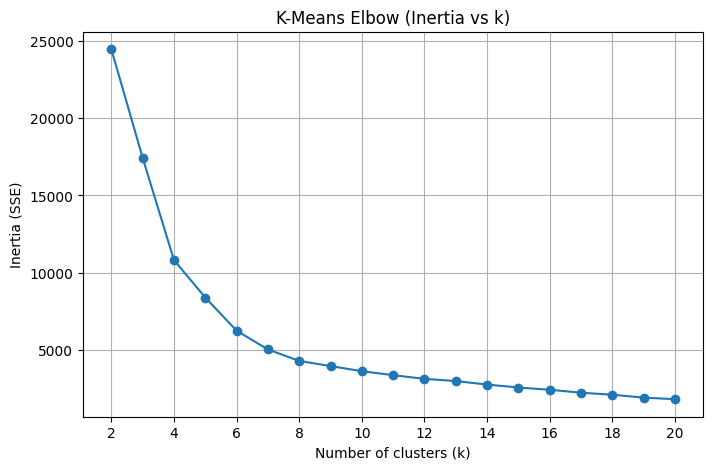

In [ ]:
X_source = X_umap
k_values = range(2, 21)
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    km.fit(X_source)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(list(k_values), inertias, marker='o')
plt.title("K-Means Elbow (Inertia vs k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()